In [1]:
import matplotlib.pyplot as plt
import numpy as np
import yaml
import h5py
from pathlib import Path
import sys

sys.path.append("../lib/")
import matplotlib.pyplot as plt
from figparams import *

plt.rcParams.update(rc_params)
from utils import *
import average_envelope as envelope

In [2]:
colors_tot = get_colormap_colors(24, "plasma")
colors = colors_tot[:12][::-1]

In [3]:
def load_posterior_data(
    n_packs=24,
    mode="your_mode_here",
    folder="/home/utente/BAHAMAS/bahamas/data/finalgalaxy/first_year_egf/",
):
    """
    Load posterior samples from HDF5 files and corresponding true values from YAML

    Parameters:
    -----------
    n_packs : int
        Number of packs to load
    mode : str
        Mode for the analysis

    Returns:
    --------
    all_samples : list
        List of posterior samples for each pack
    parameter_names : list
        Names of the parameters
    true_values : list
        True injected values for each pack
    """

    all_samples = []
    all_true_values = []
    parameter_names = None

    for i in range(n_packs):
        pack_id = i + 1

        # Load posterior samples from HDF5
        hdf5_path = folder + f"pack_{pack_id}/nessai/Gamma/{mode}/result.hdf5"

        if not Path(hdf5_path).exists():
            print(f"Warning: {hdf5_path} not found, skipping pack_{pack_id}")
            continue

        try:
            with h5py.File(hdf5_path, "r") as f:
                posterior = f["posterior_samples"][:]
                # Get parameter names from dtype (first time only)
                if parameter_names is None:
                    dtype = posterior.dtype
                    parameter_names = list(dtype.names)

        except Exception as e:
            print(f"Error loading {hdf5_path}: {e}")
            continue

        # Load true values from YAML
        if mode == "noegf":
            yaml_path = (
                folder
                + f"pack_{pack_id}/nessai/Gamma/{mode}/pe_pack{pack_id}_cyclo.yaml"
            )
        else:
            yaml_path = (
                folder
                + f"pack_{pack_id}/nessai/Gamma/{mode}/pe_pack{pack_id}_{mode}.yaml"
            )
            print(yaml_path)

        if Path(yaml_path).exists():
            try:
                with open(yaml_path, "r") as file:
                    sources = yaml.safe_load(file)["sources"]
                    true_values = [
                        item["injected"]
                        for category in sources.values()
                        for item in category
                    ]
            except Exception as e:
                print(f"Error loading {yaml_path}: {e}")
                true_values = [0] * len(parameter_names)
        else:
            print(f"Warning: {yaml_path} not found, using zeros for true values")
            true_values = [0] * len(parameter_names) if parameter_names else []

        # Convert structured array to regular array
        if parameter_names and len(true_values) > 0:
            n_params = min(len(parameter_names), len(true_values))
            samples = np.vstack(
                [posterior[name] for name in parameter_names[:n_params]]
            ).T

            all_samples.append(samples)
            all_true_values.append(true_values[:n_params])

    return (
        all_samples,
        parameter_names[: len(true_values)] if parameter_names else [],
        all_true_values,
    )

In [ ]:
all_samples, parameter_names, all_true_values = load_posterior_data(
    n_packs=24,
    mode="noegf",  # NOTE: Adjust 'mode = cyclo' to get top panel.
    folder="../data/first_year_egf/",
)


../data/first_year_egf/pack_1/nessai/Gamma/cyclo/pe_pack1_cyclo.yaml
../data/first_year_egf/pack_2/nessai/Gamma/cyclo/pe_pack2_cyclo.yaml
../data/first_year_egf/pack_3/nessai/Gamma/cyclo/pe_pack3_cyclo.yaml
../data/first_year_egf/pack_4/nessai/Gamma/cyclo/pe_pack4_cyclo.yaml
../data/first_year_egf/pack_5/nessai/Gamma/cyclo/pe_pack5_cyclo.yaml
../data/first_year_egf/pack_6/nessai/Gamma/cyclo/pe_pack6_cyclo.yaml
../data/first_year_egf/pack_7/nessai/Gamma/cyclo/pe_pack7_cyclo.yaml
../data/first_year_egf/pack_8/nessai/Gamma/cyclo/pe_pack8_cyclo.yaml
../data/first_year_egf/pack_9/nessai/Gamma/cyclo/pe_pack9_cyclo.yaml
../data/first_year_egf/pack_10/nessai/Gamma/cyclo/pe_pack10_cyclo.yaml
../data/first_year_egf/pack_11/nessai/Gamma/cyclo/pe_pack11_cyclo.yaml
../data/first_year_egf/pack_12/nessai/Gamma/cyclo/pe_pack12_cyclo.yaml
../data/first_year_egf/pack_13/nessai/Gamma/cyclo/pe_pack13_cyclo.yaml
../data/first_year_egf/pack_14/nessai/Gamma/cyclo/pe_pack14_cyclo.yaml
../data/first_year_egf/p

In [10]:
mod_par = ["lat", "long", "psi", "s1", "s2"]

# select from all_samples only the parameters in mod_par
mod_indices = [parameter_names.index(p) for p in mod_par if p in parameter_names]
mod_samples = [samples[:, mod_indices] for samples in all_samples]
mod_param_names = [parameter_names[i] for i in mod_indices]
mod_true_values = [[true[i] for i in mod_indices] for true in all_true_values]
mod_true_values = mod_true_values[0]

print(mod_true_values)

[-0.09664565, -1.6259238, -0.9900146151015816, 0.04156049812924856, 0.13842963137295858]


In [11]:
year = 31557600.0
packets = [4, 11, 23]

In [12]:
true_mod = []
for k in range(len(packets)):
    packet = packets[k]
    time = np.loadtxt(f"../data/first_year_egf/pack_{24}/time_interval.txt")
    true_mod.append(
        envelope.average_envelopes_gaussian(
            mod_true_values[0],
            mod_true_values[1],
            mod_true_values[3],
            mod_true_values[4],
            mod_true_values[2],
            time[0],
            time[-1],
            1 / year,
            alpha0=0.0,
            beta0=0.0,
            tdi=1,
        )
    )

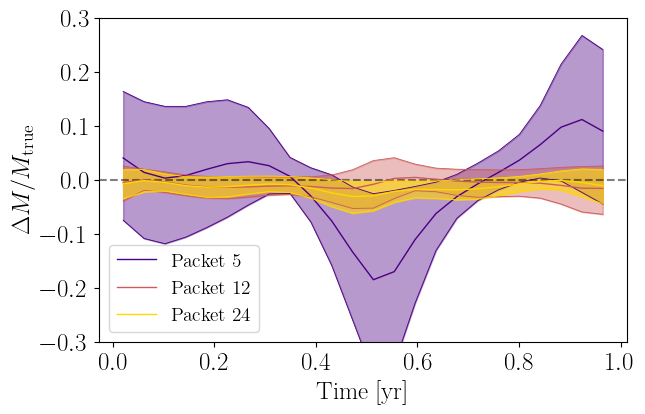

In [ ]:
# Increase figure size for better readability
plt.figure(figsize=rect_size)

# Reference line
plt.axhline(0, color="k", linestyle="--", alpha=0.5, lw=1.5)

for k in range(len(packets)):
    packet = packets[k]
    time = np.loadtxt(f"../data/first_year_egf/pack_{24}/time_interval.txt")
    sam = []
    for i in range(len(mod_samples[packet])):
        sam.append(
            envelope.average_envelopes_gaussian(
                mod_samples[packet][i][0],
                mod_samples[packet][i][1],
                mod_samples[packet][i][3],
                mod_samples[packet][i][4],
                mod_samples[packet][i][2],
                time[0],
                time[-1],
                1 / year,
                alpha0=0.0,
                beta0=0.0,
                tdi=1,
            )
        )
    sam = np.array(sam)
    p5 = np.percentile(sam, 5, axis=0)
    p50 = np.percentile(sam, 50, axis=0)
    p95 = np.percentile(sam, 95, axis=0)

    # if packet == 23:
    #     edgecolor = "k"
    #     ecolor = "goldenrod"
    # else:
    #     edgecolor = None
    #     ecolor = None
    # Improved error bars with thinner lines and smaller caps

    # plt.errorbar(
    #     0.5 * (time[0] + time[1]) / year,
    #     (true_mod[-1] - p50) / p50,
    #     [(p50 - p5) / p50, (p95 - p50) / p50],
    #     color=colors_tot[packet],
    #     fmt="D",
    #     label="90% Credible Interval",
    #     markeredgecolor=edgecolor,
    #     ecolor=ecolor,
    #     alpha=0.7,
    #     capsize=5,
    #     capthick=2.5,
    #     elinewidth=0.8,
    #     markersize=6,
    # )

    # Instead of error bars, plot a median line, and a shaded region for the 5-95 percentiles
    # If packet == 23, use 'goldenrod' as the original color is too bright
    if packet == 23:
        color = "gold"
        alpha = 0.6
    else:
        color = colors_tot[packet]
        alpha = 0.4

    plt.plot(
        0.5 * (time[0] + time[1]) / year,
        (true_mod[-1] - p50) / true_mod[-1],
        color=color,
        #        marker="o",
        label=f"Packet {packet + 1}",
        alpha=1,
        #       markersize=3,
        lw=1.0,
    )
    plt.plot(
        0.5 * (time[0] + time[1]) / year,
        (true_mod[-1] - p5) / true_mod[-1],
        color=color,
        label=f"__nolegend__",
        ls="-",
        lw=0.6,
    )
    plt.plot(
        0.5 * (time[0] + time[1]) / year,
        (true_mod[-1] - p95) / true_mod[-1],
        color=color,
        label=f"__nolegend__",
        ls="-",
        lw=0.6,
    )
    plt.fill_between(
        0.5 * (time[0] + time[1]) / year,
        (true_mod[-1] - p5) / true_mod[-1],
        (true_mod[-1] - p95) / true_mod[-1],
        color=color,
        alpha=alpha,
        edgecolor=color,
    )

# Improved axis labels and formatting
plt.xlabel("Time [yr]")
plt.ylabel("$\\Delta M / M_{\\rm true}$")
plt.tick_params(axis="both", which="major")
plt.ylim(-0.3, 0.3)
plt.legend(loc="lower left", fontsize=14)
plt.savefig("../plots/Figure8Bottom.pdf", dpi=300, bbox_inches="tight")
# NOTE: Adjust 'mode = cyclo' and uncomment to get top panel.
# plt.savefig("../plots/Figure8Top.pdf", dpi=300, bbox_inches="tight")
